<a href="https://colab.research.google.com/github/fengtastics/111-Capstone/blob/master/Arterra_Project_holtwinter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [337]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib

from fbprophet import Prophet


# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.api import qqplot


matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'

In [338]:
#raw_df = pd.read_csv("C:\\Users\\mcinn\\Documents\\timeseries_vqa.csv")
raw_df = pd.read_csv("timeseries_fixeddate.csv",encoding='latin-1')   
#raw_df = pd.read_csv("timeseries_fixeddate.csv")     
   
raw_df.head()
#raw_df.info()

,ï»¿Region,Actual Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,9L Cases
0,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1
1,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0
2,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0
3,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8
4,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13


In [339]:
# replace Sales Dollar , 9L Cases to NUMBERS format

raw_df['9L Cases'] = raw_df['9L Cases'].str.replace(',', '').astype(float)
raw_df.head()



,ï»¿Region,Actual Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,9L Cases
0,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [340]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211587 entries, 0 to 211586
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ï»¿Region                   211587 non-null  object 
 1   Actual Date                 211587 non-null  object 
 2   AWC Fiscal Year Month Abbr  211587 non-null  object 
 3   AWC FYr & Pd No             211587 non-null  int64  
 4   Country Group               211587 non-null  object 
 5   AWC and Comp                211587 non-null  object 
 6   Varietal                    211567 non-null  object 
 7   Brand                       211587 non-null  object 
 8   Channel                     211587 non-null  object 
 9   Unit Size                   211587 non-null  int64  
 10  9L Cases                    211587 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 17.8+ MB


In [348]:
raw_df = raw_df.rename({'Actual Date': 'Date','9L Cases':'cases','ï»¿Region':'Region'}, axis=1) 

#raw_df['Date'] = raw_df['Date'].str[1:]
raw_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
0,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [349]:
#import datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
0,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [350]:
raw_df['Date'].min(), raw_df['Date'].max()

(Timestamp('2016-03-01 00:00:00'), Timestamp('2021-01-01 00:00:00'))

In [351]:
raw_df['Country Group'].unique()


array(['CANADA-ICB', 'CANADA-VQA'], dtype=object)

In [352]:
raw_df['Channel'].unique()

array(['Grocery Scan', 'Regular OTC Sales', 'IND RETAILERS - SHIPMENTS',
       'BC LIQUOR STORES - OVER THE COUNTER'], dtype=object)

In [353]:

#ICB
icb_df = raw_df.loc[raw_df['Country Group'] == 'CANADA-ICB']
bc_icb_df = icb_df.loc[icb_df['Region'] == 'BC']
ont_icb_df=icb_df.loc[icb_df['Region'] == 'ONT']

#VQA
vqa_df = raw_df.loc[raw_df['Country Group'] == 'CANADA-VQA']
bc_vqa_df = vqa_df.loc[vqa_df['Region'] == 'BC']
ont_vaq_df=vqa_df.loc[vqa_df['Region'] == 'ONT']


#Channel

BC_ind_df = raw_df.loc[raw_df['Channel'] == 'IND RETAILERS - SHIPMENTS']
BC_OTC_df = raw_df.loc[raw_df['Channel'] == 'BC LIQUOR STORES - OVER THE COUNTER']

ONT_groc_df = raw_df.loc[raw_df['Channel'] == 'Grocery Scan']
ONT_OTC_df = raw_df.loc[raw_df['Channel'] == 'Regular OTC Sales']



In [354]:
#audit
bc_vqa_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
1157,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,KERNER,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1158,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,MERLOT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1159,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1160,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,ZWEIGELT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1161,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0927363 BC LTD. - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0


### TRY 1 Country group


In [355]:
bc_icb_df.head()


,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
1213,BC,2020-12-01,F2021 DEC,202110,CANADA-ICB,COMPETITOR,ROSE,40 KNOTS,IND RETAILERS - SHIPMENTS,1500,0.0
1215,BC,2020-12-01,F2021 DEC,202110,CANADA-ICB,COMPETITOR,GAMAY,40 KNOTS,IND RETAILERS - SHIPMENTS,750,7.0
1216,BC,2020-12-01,F2021 DEC,202110,CANADA-ICB,COMPETITOR,MERITAGE,40 KNOTS,IND RETAILERS - SHIPMENTS,750,1.0
1217,BC,2020-12-01,F2021 DEC,202110,CANADA-ICB,COMPETITOR,MERLOT,40 KNOTS,IND RETAILERS - SHIPMENTS,750,0.0
1219,BC,2020-12-01,F2021 DEC,202110,CANADA-ICB,COMPETITOR,PINOT GRIGIO,40 KNOTS,IND RETAILERS - SHIPMENTS,750,12.0


In [356]:
bc_icb_df['Region'].unique()

array(['BC'], dtype=object)

In [357]:
bc_icb_df.isnull().sum()


Region                        0
Date                          0
AWC Fiscal Year Month Abbr    0
AWC FYr & Pd No               0
Country Group                 0
AWC and Comp                  0
Varietal                      0
Brand                         0
Channel                       0
Unit Size                     0
cases                         0
dtype: int64

##  CHANGE   DF NAME MIXEDUP  HERE!!!!!!!!! ###


In [390]:

#bc_icb_region_cases=bc_icb_df.groupby(['Date'])['cases'].sum().reset_index()
bc_ind_df_cases=BC_ind_df.groupby(['Date'])['cases'].sum().reset_index()
bc_icb_region_cases=bc_ind_df_cases

bc_icb_region_cases.tail()

,Date,cases
42,2020-08-01,185422.0
43,2020-09-01,139236.0
44,2020-10-01,175098.0
45,2020-11-01,162079.0
46,2020-12-01,213694.0


# MODEL BEGINS HERE

In [391]:
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Differencing 

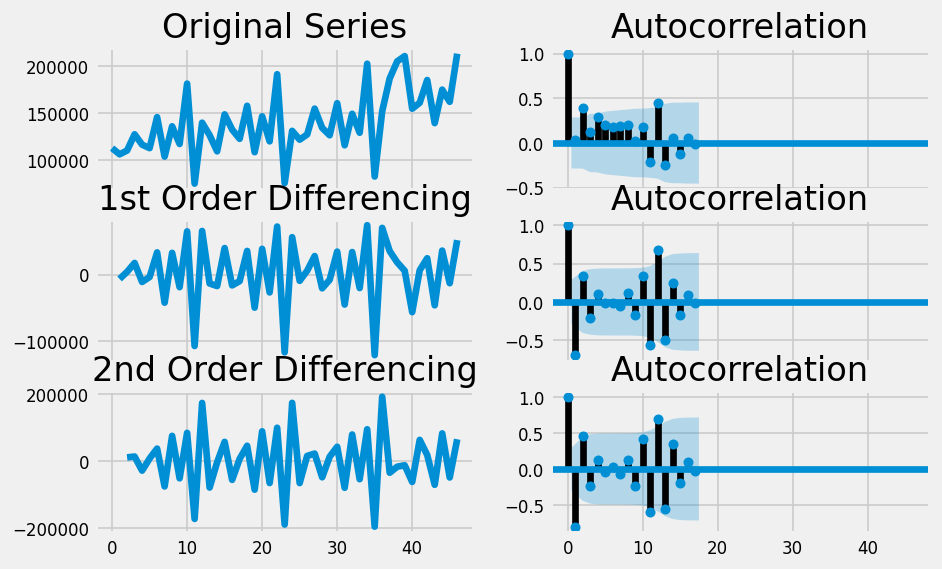

In [392]:
#
#ICB

plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(bc_icb_region_cases.cases); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(bc_icb_region_cases.cases, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(bc_icb_region_cases.cases.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(bc_icb_region_cases.cases.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(bc_icb_region_cases.cases.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(bc_icb_region_cases.cases.diff().diff().dropna(), ax=axes[2, 1])

## we need *2nd* order differencing


plt.show()

In [310]:
##  ARMA MODEL BEGIN HERE 

In [393]:
# VQA statistics
from statsmodels.tsa.stattools import adfuller

result = adfuller(bc_icb_region_cases['cases'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.6353911235884593
p-value: 0.08590099588961514
Critical Values:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937


## FORECASTING BEGINS HERE 


In [394]:
#set index
bc_icb_region_cases_ts = bc_icb_region_cases.set_index('Date')


In [395]:
bc_icb_region_cases_ts.head()

,cases
Date,
2017-02-01,112434.0
2017-03-01,105760.0
2017-04-01,109840.0
2017-05-01,127235.0
2017-06-01,116091.0


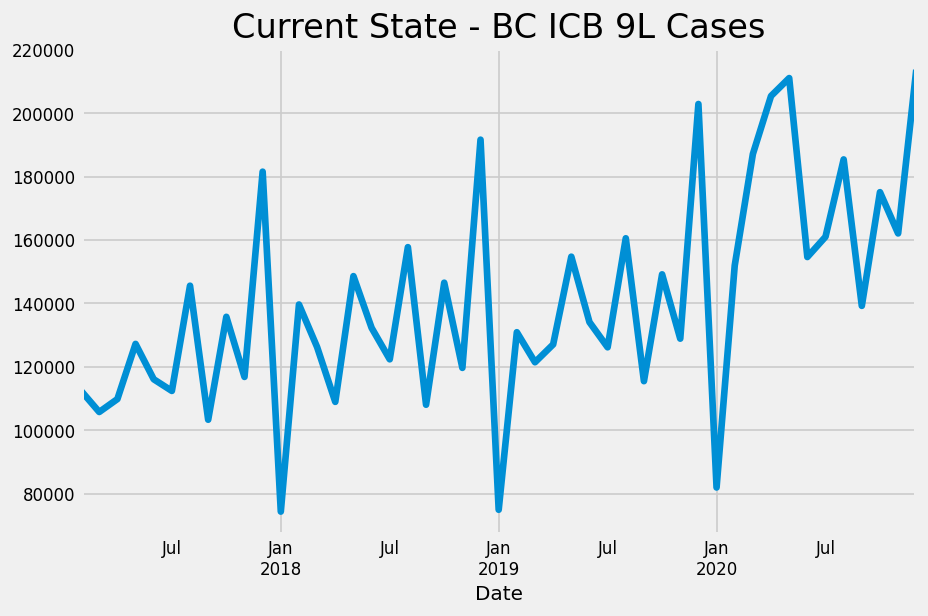

In [396]:
# plotting the original data
bc_icb_region_cases_ts['cases'].plot(title='Current State - BC ICB 9L Cases')

In [397]:
# finding shape of the dataframe
print(bc_icb_region_cases_ts.shape)


(47, 1)


In [398]:
bc_icb_region_cases_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2017-02-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cases   47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [399]:
bc_icb_region_cases_ts.head()

,cases
Date,
2017-02-01,112434.0
2017-03-01,105760.0
2017-04-01,109840.0
2017-05-01,127235.0
2017-06-01,116091.0


In [400]:
bc_icb_region_cases_ts.index


DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [401]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = bc_icb_region_cases_ts.cases[:32]  #47 records. 32 for train. 
test = bc_icb_region_cases_ts.cases[32:]

##  ARIMA  

                             ARIMA Model Results                              
Dep. Variable:                D.cases   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -352.506
Method:                       css-mle   S.D. of innovations          19433.848
Date:                Sun, 21 Feb 2021   AIC                            713.013
Time:                        04:08:38   BIC                            718.749
Sample:                    03-01-2017   HQIC                           714.882
                         - 09-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           679.9252    242.247      2.807      0.009     205.130    1154.720
ar.L1.D.cases    -0.5916      0.140     -4.216      0.000      -0.867      -0.317
ma.L1.D.cases    -1.0000      0.097    -

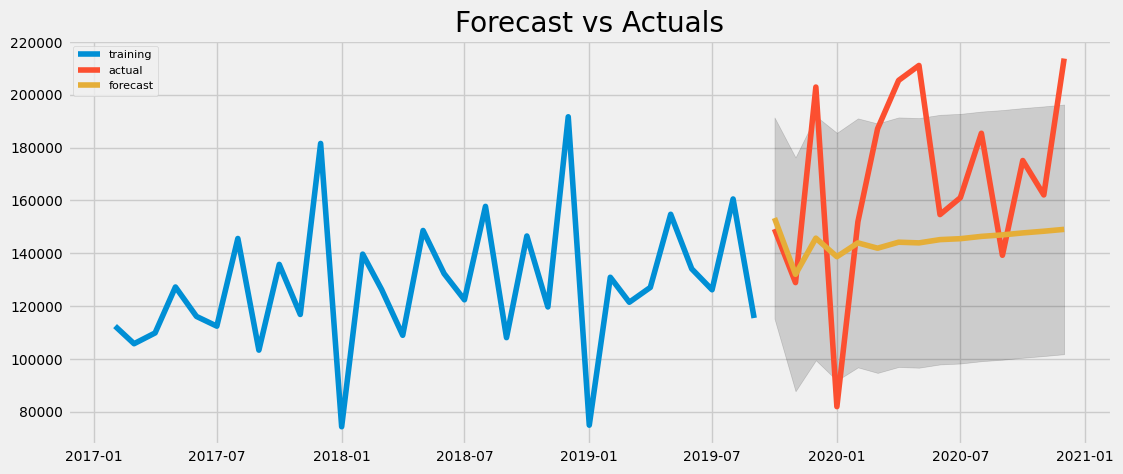

In [407]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [408]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [409]:
forecast_accuracy(fc, test.values)

{'acf1': -0.0729950545758864,
 'corr': 0.38787938289926516,
 'mae': 32026.71990856718,
 'mape': 0.19364129818911327,
 'me': -22460.701824582546,
 'minmax': 0.1744686495638258,
 'mpe': -0.08696916515717748,
 'rmse': 39934.385537928865}

#  END     OLD  CODE  #
